<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Teoría de los Circuitos 2

# Trabajo Semanal 9

### Jorge Andres Niño


## Consigna

Resolver los puntos mostrados a continuación:

![*Figura 8*](TS9_niño_2.png)

### Resolución

A continuación se presenta la resolución mediante uso de script en python y las bibliotecas necesarias.

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 18 16:22:31 2023

@author: alumno
"""

# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
from scipy.signal import freqz
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla
import zplane as zp
def group_delay(ww, phase):
    
    groupDelay = -np.diff(phase)/np.diff(ww)
    
    return(np.append(groupDelay, groupDelay[-1]))


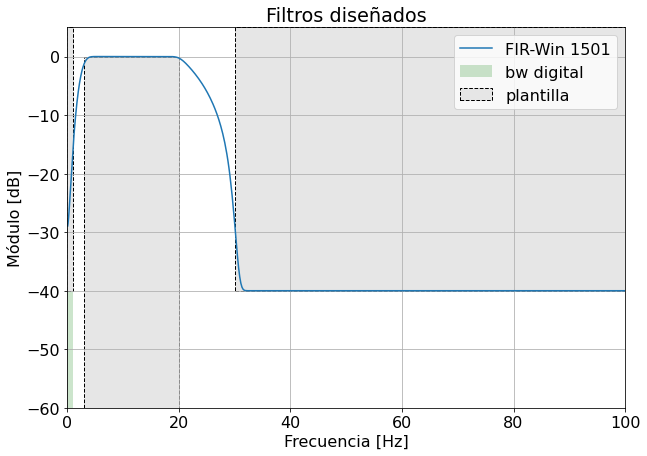

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


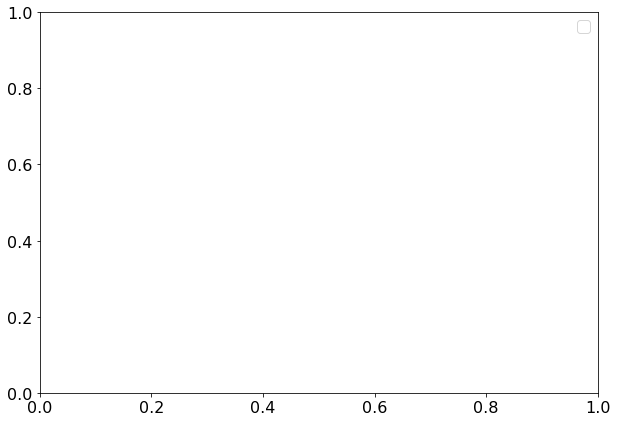

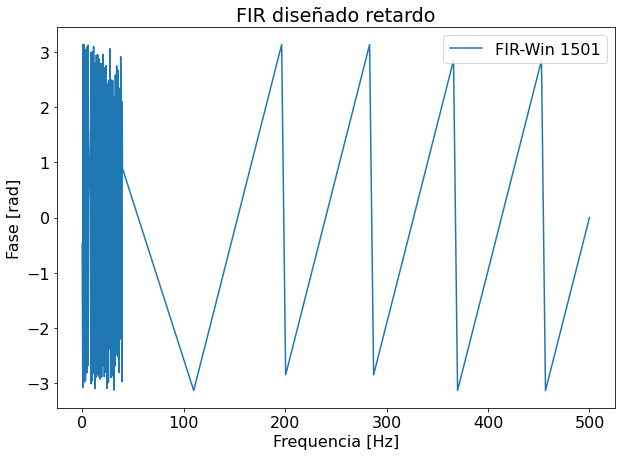

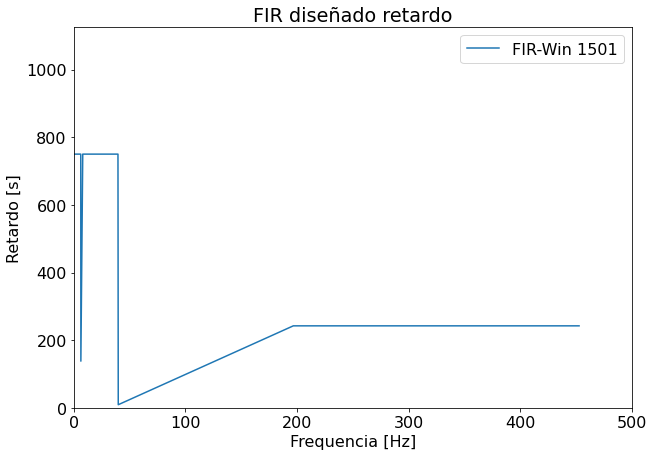

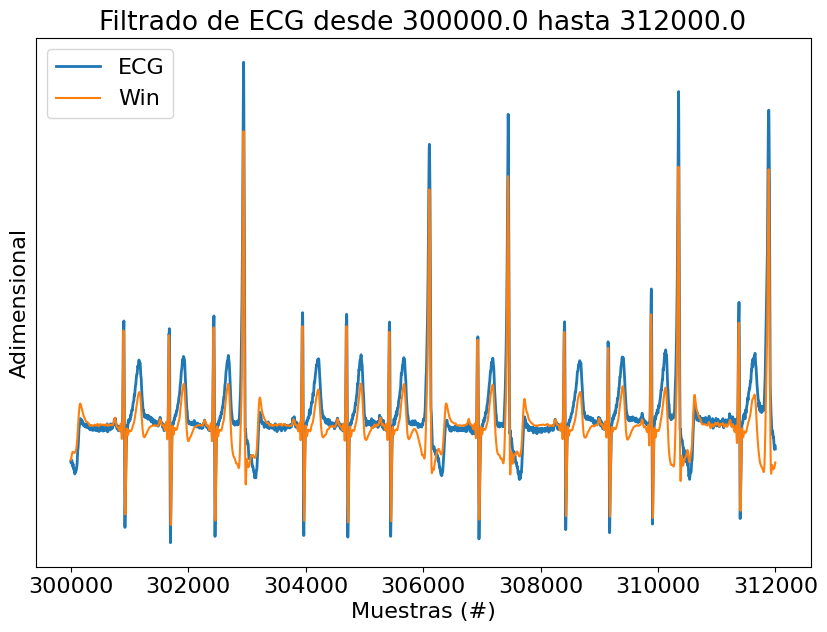

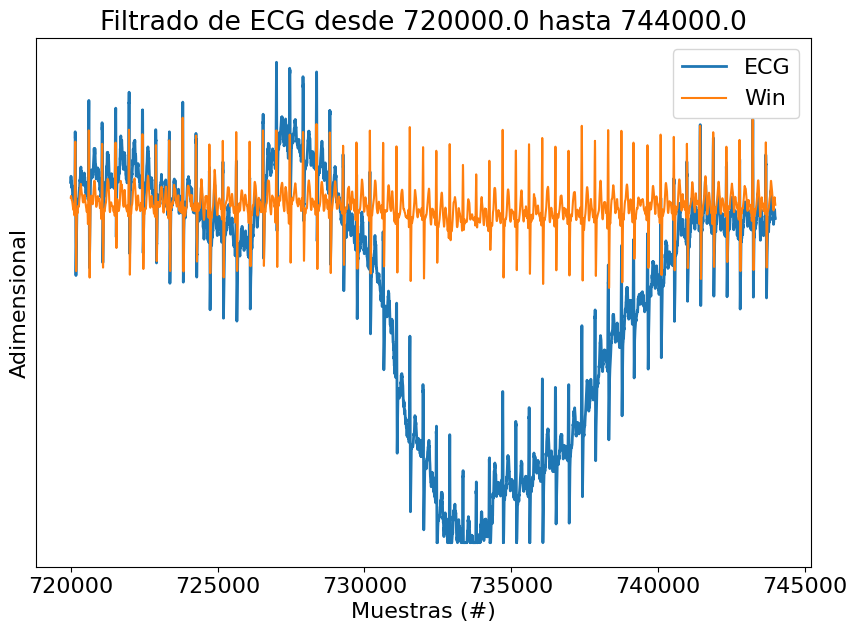

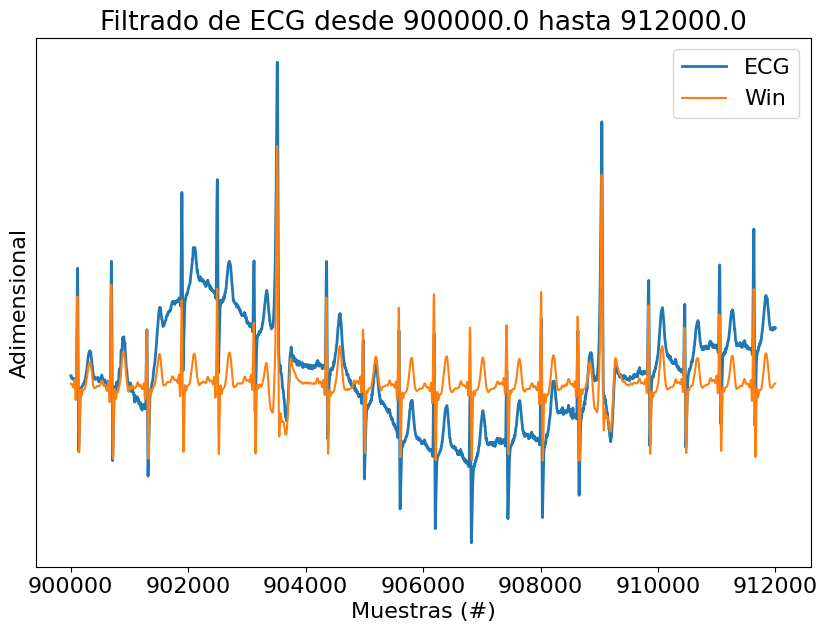

In [9]:
fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100  # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
plt.rcParams.update({'font.size': fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#sio.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000  # Hz
nyq_frec = fs / 2

#Plantilla

# filter design
ripple = 0 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 20.0 #Hz
ws2 = 30.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)
cant_coeficientes = 1501
num_win = sig.firwin2(cant_coeficientes, frecs, gains , window='blackmanharris' )
#num_firls_bp = sig.firls(1200, frecs, gains, fs=fs)
#num_remez_bp = sig.remez(1200, frecs, gains[::2], fs=fs)
#num_firls_hp = sig.firls(300, frecs, gains, fs=fs)
#num_remez_hp = sig.remez(300, frecs, gains[::2], fs=fs)
#bp_sos_butter, den = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='butter', output='ba')
den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
#w_rad  = np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250) )
#w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) ) / nyq_frec * np.pi
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, hh_win = sig.freqz(num_win, den, w)
#_, h_butter = sig.sosfreqz(bp_sos_butter, w_rad)
#_, h_butter = sig.freqz(bp_sos_butter, den)
# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec
demora = 750


plt.close('all')

plt.figure(1)
plt.clf()
plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))
#plt.plot(_, 20*np.log10(np.abs(h_butter)+1e-12), label='IIR-Butter {:d}'.format(bp_sos_butter.shape[0]) )
#plt.plot(_, 20*np.log10(np.abs(h_butter)), label='IIR-Butter {:d}'.format(bp_sos_butter.shape[0]) )
plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion)

axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()

plt.figure(2)

phase_win = np.angle(hh_win)


plt.plot(w, phase_win, label='FIR-Win {:d}'.format(num_win.shape[0]))    # Bode phase plot

plt.title('FIR diseñado retardo')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Fase [rad]')

axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()

plt.figure(3)

gd_win = group_delay(_, phase_win)

# Para órdenes grandes 
plt.plot(w[gd_win>0], gd_win[gd_win>0], label='FIR-Win {:d}'.format(num_win.shape[0]))    # Bode phase plot

plt.axis([0, 500, 0, 1.5*demora ])

plt.title('FIR diseñado retardo')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Retardo [s]')

axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()


# IIR
# ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)

# FIR
ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)
# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.



# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('Filtrado de ECG desde ' + str(ii[0]) + ' hasta ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

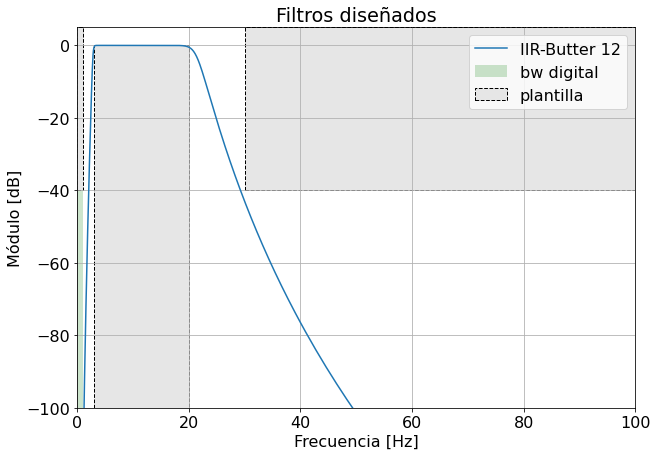

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


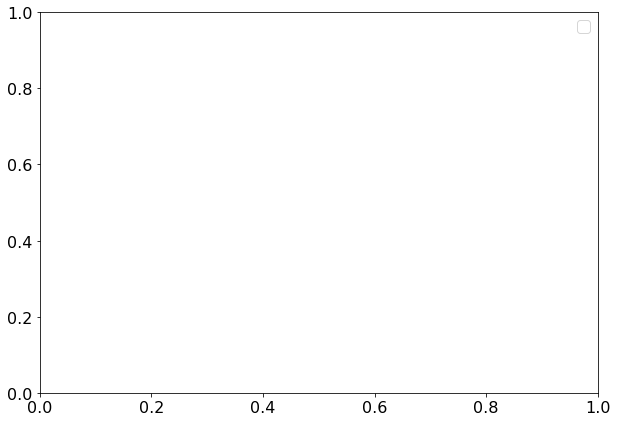

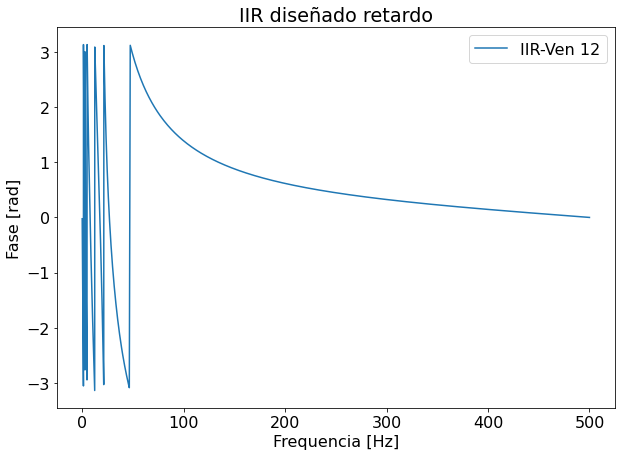

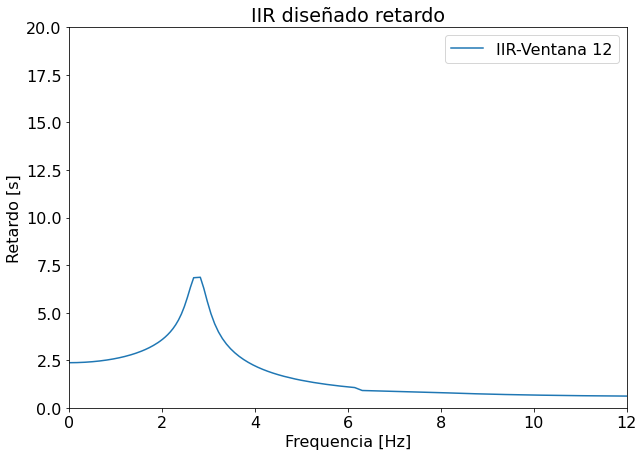

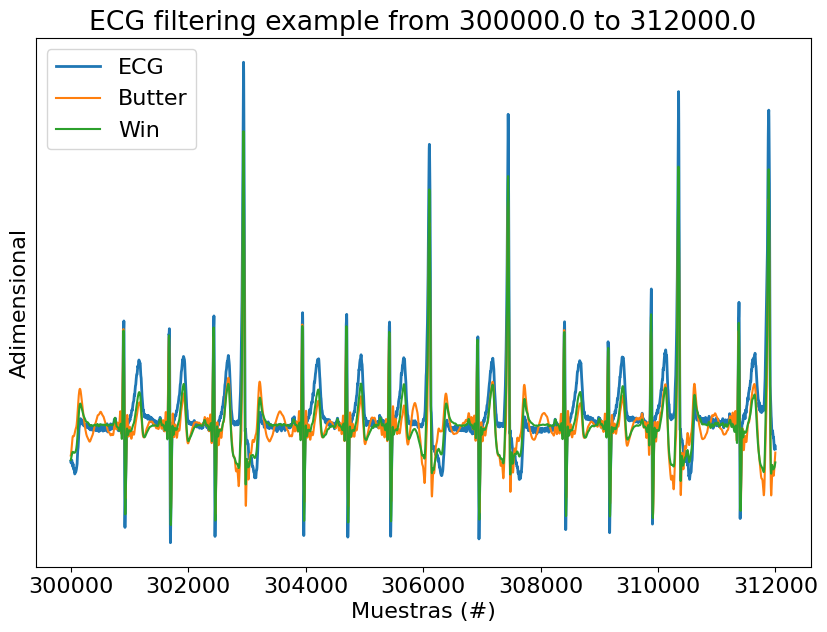

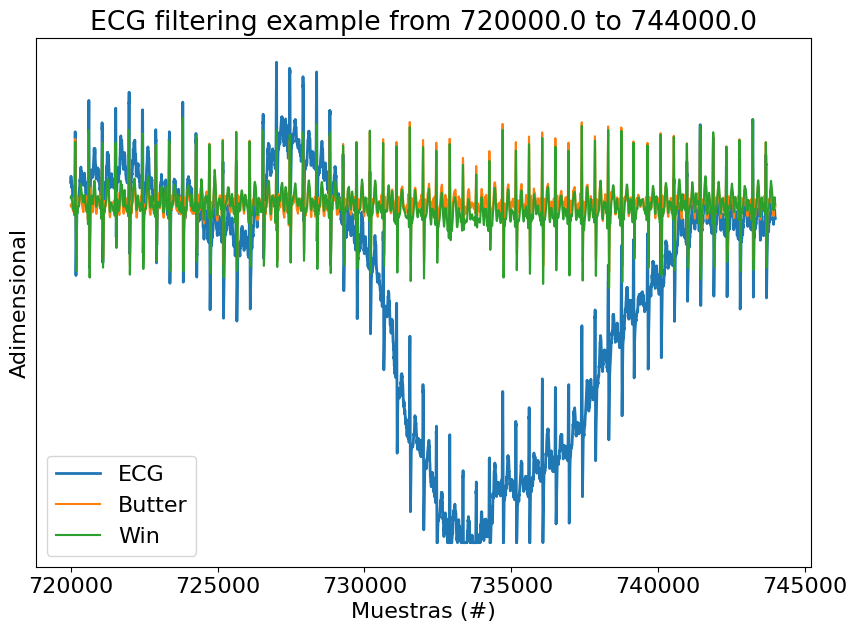

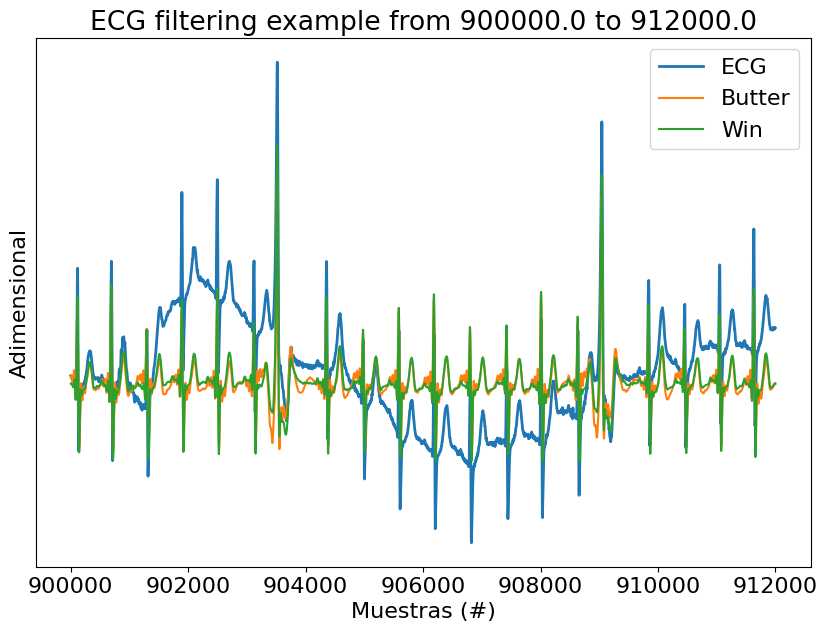

In [18]:
fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100  # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
plt.rcParams.update({'font.size': fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#sio.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000  # Hz
nyq_frec = fs / 2
demora = 750
#Plantilla

# filter design
ripple = 0 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 20.0 #Hz
ws2 = 30.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)
#num_firls_bp = sig.firls(1200, frecs, gains, fs=fs)
#num_remez_bp = sig.remez(1200, frecs, gains[::2], fs=fs)
#num_firls_hp = sig.firls(300, frecs, gains, fs=fs)
#num_remez_hp = sig.remez(300, frecs, gains[::2], fs=fs)
#bp_sos_butter, den = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='butter', output='ba')
bp_sos_butter = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='butter', output='sos')
den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w_rad  = np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) ) / nyq_frec * np.pi
#w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
#w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

#_, hh_win = sig.freqz(num_win, den, w)
_, h_butter = sig.sosfreqz(bp_sos_butter, w_rad)

#_, h_butter = sig.freqz(bp_sos_butter, den)
# renormalizo el eje de frecuencia
_ = _ / np.pi * nyq_frec
plt.close('all')

plt.figure(1)
plt.clf()
#plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))
plt.plot(_, 20*np.log10(np.abs(h_butter)), label='IIR-Butter {:d}'.format(bp_sos_butter.shape[0]) )
#plt.plot(_, 20*np.log10(np.abs(h_butter)), label='IIR-Butter {:d}'.format(bp_sos_butter.shape[0]) )
plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -100, 5 ]);

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion)
axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()

plt.figure(2)

phase_win = np.angle(h_butter)


plt.plot(_, phase_win, label='IIR-Ven {:d}'.format(bp_sos_butter.shape[0]))    # Bode phase plot

plt.title('IIR diseñado retardo')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Fase [rad]')

axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()

plt.figure(3)

gd_win = group_delay(_, phase_win)

# Para órdenes grandes 
plt.plot(_[gd_win>0], gd_win[gd_win>0], label='IIR-Ventana {:d}'.format(bp_sos_butter.shape[0]))    # Bode phase plot

plt.axis([0, 12, 0, 20 ])

plt.title('IIR diseñado retardo')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Retardo [s]')

axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()


# IIR
ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)

# FIR
#ECG_f_win = sig.lfilter(bp_sos_butter, den, ecg_one_lead)
# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 750


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()